In [35]:
import numpy as np
import matplotlib
#matplotlib.use('Agg')

import matplotlib.pyplot as plt
import pickle as pkl

from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, Module
from torch.nn.init import kaiming_uniform_, xavier_uniform_
import torch.nn as nn

np.random.seed(0)

import torch
import geomloss

In [36]:
DIM = 64 # Model dimensionality (number of neurons in the hidden layer(s))
CRITIC_ITERS = 5 # How many critic iterations (Sinkhorn iterations) per generator iteration#was 50
BATCH_SIZE = 256 # Batch size
EPOCHS = 10#55#100000 # how many generator iterations to train for
DATA_DIM = 32
LATENT_DIM = 8
INITIALIZATION = 'he'#'glorot'
COVARIANCE_SCALE = np.sqrt(DATA_DIM)
INITIALIZE_LAST = True
SAMPLE_SIZE = 100000
LAMBDA = .5#2/(COVARIANCE_SCALE)
MODE = 'divergence' #'loss', 'wgan-wc', 'wgan-gp'
PARAMETRIC = True

In [37]:
def initializer(weight):
    if INITIALIZATION == 'he':
        return kaiming_uniform_(weight, nonlinearity='relu')
    if INITIALIZATION == 'glorot':
        return xavier_uniform_(weight)
    print("UNKNOWN INITIALIZATION")
    return None

def init_weights(m):
    if type(m) == nn.Linear:
        initializer(m.weight)

In [4]:
class GaussianDataset(Dataset):
    # reading the csv and defining predictor and output columns
    def __init__(self, sample_size=SAMPLE_SIZE, data_dim=DATA_DIM, latent_dim = LATENT_DIM,
                 variance = 1/COVARIANCE_SCALE):
    
        # store the input and output features
        
        np.random.seed(1)
        self.X = np.random.randn(sample_size,data_dim) * np.sqrt(variance)
        self.latent_dim = latent_dim
    
        # ensure all data is numerical - type(float)
        self.X = self.X.astype('float32')
    
    # number of rows in dataset
    def __len__(self):
        return len(self.X)
    
    # get a row at an index
    def __getitem__(self, index):
        return [np.random.randn(self.latent_dim).astype('float32'), self.X[index], 
                np.random.randn(self.latent_dim).astype('float32'), 
                np.random.randn(self.latent_dim).astype('float32')]
dataset = GaussianDataset()
data_dl = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
class Generator(Module):
    def __init__(self, n_inputs = LATENT_DIM):
        super(Generator, self).__init__()

        self.model = nn.Sequential(        
        # defining the inputs to the first hidden layer
            Linear(n_inputs, DIM) ,
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, DATA_DIM),
        )
        self.model.apply(init_weights)

    def forward(self, X):
        X = self.model(X)
        return X

class Discriminator(Module):
    def __init__(self, n_inputs = DATA_DIM):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(        
        # defining the inputs to the first hidden layer
            Linear(n_inputs, DIM) ,
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, 1),
        )
        self.model.apply(init_weights)

    def forward(self, X):
        X = self.model(X)
        return X
    
class SGAN(Module):
    def __init__(self, n_inputs = LATENT_DIM, n_):
        super(SGAN, self).__init__()

        self.model = nn.Sequential(        
        # defining the inputs to the first hidden layer
            Linear(n_inputs, DIM) ,
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, 1),
        )
        self.model.apply(init_weights)

    def forward(self, X):
        X = self.model(X)
        return X

In [21]:
# Initialize generator and discriminator and optimizers
generator = Generator()
optimizer_G = torch.optim.Adam(generator.parameters(), lr = 0.003)



if PARAMETRIC or (MODE in ['wgan-wc', 'wgan-gp']):
    discriminator_fake = Discriminator() #for fake data (hat_Y) in W(Y, hat_Y)
    optimizer_Df = torch.optim.RMSprop(discriminator_fake.parameters(),lr=0.005)
    optimizers_disc = [optimizer_Df] #discriminator optimizers
    
    if MODE == 'divergence':
        discriminator_real = Discriminator() #for real data (Y) in W(Y, hat_Y)
        optimizer_Dr = torch.optim.RMSprop(discriminator_real.parameters(),lr=0.005)
        optimizers_disc += [optimizer_Dr]
        
        discriminator_ff = Discriminator() #for fake data (hat_Y) in W(hat_Y, hat_Y)
        optimizer_Dff = torch.optim.RMSprop(discriminator_ff.parameters(), lr = 0.01)
        optimizers_disc += [optimizer_Dff]

In [33]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr = 0.003)
optimizer_Df = torch.optim.RMSprop(discriminator_fake.parameters(),lr=0.005)
optimizer_Dr = torch.optim.RMSprop(discriminator_real.parameters(),lr=0.005)
optimizer_Dff = torch.optim.RMSprop(discriminator_ff.parameters(), lr = 0.01)

In [8]:
from geomloss.utils import squared_distances

In [9]:
eps = LAMBDA#CHANGE TO APPLY TO SINKHORN!!!
def entropic_loss_dual(dual_fake, dual_real, cost_mat):#this is a negative loss
    log_pi = (dual_real.T+dual_fake - cost_mat)/eps
    reg_term = (log_pi).logsumexp((0,1))
    W_neg = - dual_fake.mean() - dual_real.mean() + eps*reg_term 
    return W_neg

#WE CAN MINIMIZE THE LOG OF W HERE IF THERE ARE NANS
def entropic_loss_primal(dual_fake, dual_real, cost_mat):#this is a positive loss
    log_pi = ((dual_real.T+dual_fake - cost_mat)/eps).detach()
    log_exp_norm = (log_pi + torch.log(cost_mat)).logsumexp((0,1))#log of expected norm
    W = torch.exp(log_exp_norm)
    return W

def sinkhorn_loss_primal(dual_fake, dual_real, dual_ff, fake_sample, real_sample, cost_mat, cost_mat_ff):
    log_pi = ((dual_real.T+dual_fake - cost_mat)/eps - 2* np.log(dual_fake.shape[0])).detach()
    max_log_pi = torch.max(log_pi)
    pi = torch.exp(log_pi - max_log_pi)
    pi = pi / pi.sum()
    log_pi_ff = ((dual_ff.T+dual_ff - cost_mat_ff)/eps - 2* np.log(dual_fake.shape[0])).detach()
    max_log_pi_ff = torch.max(log_pi_ff)
    pi_ff = torch.exp(log_pi_ff - max_log_pi_ff)
    pi_ff = pi_ff / pi_ff.sum()
    
    scalar1 = torch.matmul(fake_sample, real_sample.T)
    expect_scalar1 = (scalar1*pi).sum()

    scalar2 = torch.matmul(fake_sample, fake_sample.T)
    expect_scalar2 = (scalar2*pi_ff).sum()

    S = -2.0*expect_scalar1 + expect_scalar2
    return S

def sinkhorn_loss_dual(dual_fake, dual_real, dual_ff, cost_mat, cost_mat_ff):#this is a negative loss 
                                                                             #(for optimization)
    S = entropic_loss_dual(dual_fake, dual_real, cost_mat)\
            - 0.5 * entropic_loss_dual(dual_ff, dual_ff, cost_mat_ff)
    return S

In [10]:
res = {'loss':{}, 'sample': {}, 'cov_diff' : {}, 'cov_diff_accurate' : {}}
if MODE in ['divergence', 'loss']:
    res['lambda'] = LAMBDA
cov_diff_all = []
epochs = EPOCHS
VAL_STEP = 10 #compute validation every VAL_STEP iterations

In [11]:
acc_cov_diff = []

cov_diff_inp = torch.tensor(np.random.randn(10*BATCH_SIZE, LATENT_DIM).astype('float32'))

In [29]:
CRITIC_ITERS = 20

In [34]:
epochs_passed = len(list(res['loss'].keys()))#to continue training 
loss_primal = 0
for epoch in range(epochs_passed, epochs_passed+epochs):
#     if MODE == 'divergence' and PARAMETRIC:
#         if epoch == 15:
#                 optimizer_G.param_groups[0]['lr'] = 0.001
#         if epoch == 25:
#                 optimizer_G.param_groups[0]['lr'] = 0.0007
#         if epoch == 35:
#                 optimizer_G.param_groups[0]['lr'] = 0.0005
#                 optimizer_Df.param_groups[0]['lr'] = 0.0025
#                 optimizer_Dr.param_groups[0]['lr'] = 0.0025
#                 optimizer_Dff.param_groups[0]['lr'] = 0.005
    for key in res:
        if key != 'lambda':
            res[key][epoch] = []
    # go through all the batches generated by dataloader
    for i, (inputs, real_sample, inputs0, inputs1) in enumerate(data_dl):
        # clear the gradients
        for optimizer in optimizers_disc:
            optimizer.zero_grad()

        # compute the discriminator model outputs & update
        fake_sample = generator(inputs)

        cov_diff = np.linalg.norm(np.cov(np.array(fake_sample.data).T) - np.eye(DATA_DIM)/COVARIANCE_SCALE)
        cost_mat = squared_distances(fake_sample, real_sample)
        cost_mat_ff = squared_distances(fake_sample, fake_sample)
        dual_fake = discriminator_fake(fake_sample)
        dual_ff = discriminator_ff(fake_sample)
        dual_real = discriminator_real(real_sample)
        loss_w2 = entropic_loss_dual(dual_fake, dual_real, cost_mat)
        loss_w2.backward(retain_graph=True)
        optimizer_Dr.step()
        optimizer_Df.step()

        loss_neg_ent = entropic_loss_dual(dual_ff, dual_ff, cost_mat_ff)
        loss_neg_ent.backward()
        optimizer_Dff.step()

        #Sinkhorn negentropy update
        #fake_sample0 = fake_sample#generator(inputs0)
        #fake_sample1 = fake_sample#generator(inputs1)
        #cost_mat_ff = squared_distances(fake_sample0, fake_sample1)
        #dual_ff0 = discriminator_ff(fake_sample0)
        #dual_ff1 = discriminator_ff(fake_sample1)
        #loss_dual_f = sinkhorn_loss_dual(dual_ff0, dual_ff1, cost_mat_ff)
        #loss_dual_f.backward()
        #optimizer_Dff.step()
        loss_dual = loss_w2 - 0.5*loss_neg_ent
        
        if i % CRITIC_ITERS == 0 and i>0:
            # -----------------
            #  Train Generator
            # -----------------
            print("Generator step")
            optimizer_G.zero_grad()
            
            fake_sample = generator(inputs)
            cost_mat = squared_distances(fake_sample, real_sample)
            dual_fake = discriminator_fake(fake_sample)
            dual_real = discriminator_real(real_sample)
            cost_mat_ff = squared_distances(fake_sample, fake_sample)
            loss_primal = sinkhorn_loss_primal(dual_fake, dual_real, dual_ff, fake_sample,
                                             real_sample, cost_mat, cost_mat_ff)
            #fake_sample0 = generator(inputs0)
            #fake_sample1 = generator(inputs1)
            #cost_mat_ff = squared_distances(fake_sample0, fake_sample1)
            #dual_ff0 = discriminator_ff(fake_sample0)
            #dual_ff1 = discriminator_ff(fake_sample1)
            #loss_dual_f = sinkhorn_loss_dual(dual_ff0, dual_ff1, cost_mat_ff)
            
            #loss_G = - loss_dual + 0.5*loss_dual_f
            loss_primal.backward()
            optimizer_G.step()
        if i % 50 == 0:
            fake_sample = generator(cov_diff_inp)
            acc_cov_diff += [np.linalg.norm(np.cov(np.array(fake_sample.data).T) - 
                                      np.eye(DATA_DIM)/COVARIANCE_SCALE)]
        loss_dual = loss_w2-0.5*loss_neg_ent
        print("Epoch: {}, iteration {}, loss {:.4f}, loss_p {:.4f}, cov_diff {}".format(epoch,
                                                                                i, loss_dual, 
                                                                                loss_primal, cov_diff))
        res['loss'][epoch].append([loss_dual, loss_primal])
        res['sample'][epoch].append(np.array(fake_sample.data))
        res['cov_diff'][epoch].append(cov_diff)
    cov_diff_all += res['cov_diff'][epoch]

Epoch: 30, iteration 0, loss -2.2465, loss_p 0.0000, cov_diff 0.7553152107878301
Epoch: 30, iteration 1, loss -1.6496, loss_p 0.0000, cov_diff 0.7625515334414817
Epoch: 30, iteration 2, loss -1.6439, loss_p 0.0000, cov_diff 0.7611266596795976
Epoch: 30, iteration 3, loss -1.9963, loss_p 0.0000, cov_diff 0.7587621546514176
Epoch: 30, iteration 4, loss -2.0644, loss_p 0.0000, cov_diff 0.7571143114272132
Epoch: 30, iteration 5, loss -2.0958, loss_p 0.0000, cov_diff 0.7647413309683366
Epoch: 30, iteration 6, loss -2.0359, loss_p 0.0000, cov_diff 0.7707289958415676
Epoch: 30, iteration 7, loss -2.1315, loss_p 0.0000, cov_diff 0.7686986413449248
Epoch: 30, iteration 8, loss -2.2031, loss_p 0.0000, cov_diff 0.7641130575420362
Epoch: 30, iteration 9, loss -2.2204, loss_p 0.0000, cov_diff 0.7649372724702823
Epoch: 30, iteration 10, loss -2.0856, loss_p 0.0000, cov_diff 0.767581570752822
Epoch: 30, iteration 11, loss -2.1640, loss_p 0.0000, cov_diff 0.7649209211683987
Epoch: 30, iteration 12, lo

Epoch: 30, iteration 102, loss -2.3414, loss_p -0.6749, cov_diff 0.7808608445846523
Epoch: 30, iteration 103, loss -2.3058, loss_p -0.6749, cov_diff 0.783463542666187
Epoch: 30, iteration 104, loss -2.3606, loss_p -0.6749, cov_diff 0.7785015753979238
Epoch: 30, iteration 105, loss -2.4484, loss_p -0.6749, cov_diff 0.7648395772541288
Epoch: 30, iteration 106, loss -2.2677, loss_p -0.6749, cov_diff 0.7768241959671739
Epoch: 30, iteration 107, loss -2.4287, loss_p -0.6749, cov_diff 0.7736120322643377
Epoch: 30, iteration 108, loss -2.2898, loss_p -0.6749, cov_diff 0.7851354222625514
Epoch: 30, iteration 109, loss -2.3231, loss_p -0.6749, cov_diff 0.7884612263680612
Epoch: 30, iteration 110, loss -2.3458, loss_p -0.6749, cov_diff 0.7787233730117783
Epoch: 30, iteration 111, loss -2.3366, loss_p -0.6749, cov_diff 0.780591005940627
Epoch: 30, iteration 112, loss -2.3653, loss_p -0.6749, cov_diff 0.7650945104537102
Epoch: 30, iteration 113, loss -2.1921, loss_p -0.6749, cov_diff 0.78442191166

Generator step
Epoch: 30, iteration 200, loss -2.2074, loss_p -0.6712, cov_diff 0.7638981245551761
Epoch: 30, iteration 201, loss -2.2923, loss_p -0.6712, cov_diff 0.7673872087976311
Epoch: 30, iteration 202, loss -2.3831, loss_p -0.6712, cov_diff 0.7679393821230822
Epoch: 30, iteration 203, loss -2.2989, loss_p -0.6712, cov_diff 0.7697017217395032
Epoch: 30, iteration 204, loss -2.3634, loss_p -0.6712, cov_diff 0.7650306974059184
Epoch: 30, iteration 205, loss -2.1802, loss_p -0.6712, cov_diff 0.7756967303541245
Epoch: 30, iteration 206, loss -2.3757, loss_p -0.6712, cov_diff 0.7689086682417765
Epoch: 30, iteration 207, loss -2.2377, loss_p -0.6712, cov_diff 0.7688090690200416
Epoch: 30, iteration 208, loss -2.1561, loss_p -0.6712, cov_diff 0.7753457482027802
Epoch: 30, iteration 209, loss -2.2208, loss_p -0.6712, cov_diff 0.7660729522350602
Epoch: 30, iteration 210, loss -2.2344, loss_p -0.6712, cov_diff 0.7641361968330064
Epoch: 30, iteration 211, loss -2.2600, loss_p -0.6712, cov_d

Epoch: 30, iteration 298, loss -2.2921, loss_p -0.7516, cov_diff 0.7908140880744846
Epoch: 30, iteration 299, loss -2.2042, loss_p -0.7516, cov_diff 0.7831774257484714
Generator step
Epoch: 30, iteration 300, loss -2.3033, loss_p -0.8259, cov_diff 0.7799721925715405
Epoch: 30, iteration 301, loss -2.3382, loss_p -0.8259, cov_diff 0.7921576545455761
Epoch: 30, iteration 302, loss -2.3076, loss_p -0.8259, cov_diff 0.7835925470825389
Epoch: 30, iteration 303, loss -2.3299, loss_p -0.8259, cov_diff 0.7814444242868476
Epoch: 30, iteration 304, loss -2.2790, loss_p -0.8259, cov_diff 0.7896800709646115
Epoch: 30, iteration 305, loss -2.3586, loss_p -0.8259, cov_diff 0.7850992081939541
Epoch: 30, iteration 306, loss -2.3503, loss_p -0.8259, cov_diff 0.7940391415078261
Epoch: 30, iteration 307, loss -2.2560, loss_p -0.8259, cov_diff 0.7942080123761306
Epoch: 30, iteration 308, loss -2.2934, loss_p -0.8259, cov_diff 0.7882817571569628
Epoch: 30, iteration 309, loss -2.2917, loss_p -0.8259, cov_d

Epoch: 31, iteration 12, loss -2.2590, loss_p -0.8508, cov_diff 0.770983427895068
Epoch: 31, iteration 13, loss -2.2815, loss_p -0.8508, cov_diff 0.7747246109269105
Epoch: 31, iteration 14, loss -2.3118, loss_p -0.8508, cov_diff 0.7859827841689474
Epoch: 31, iteration 15, loss -2.2047, loss_p -0.8508, cov_diff 0.772334987091827
Epoch: 31, iteration 16, loss -2.2348, loss_p -0.8508, cov_diff 0.7802067036240992
Epoch: 31, iteration 17, loss -2.4295, loss_p -0.8508, cov_diff 0.7777938253389449
Epoch: 31, iteration 18, loss -2.4187, loss_p -0.8508, cov_diff 0.7768180562571428
Epoch: 31, iteration 19, loss -2.2686, loss_p -0.8508, cov_diff 0.7782647110266327
Generator step
Epoch: 31, iteration 20, loss -2.3866, loss_p -0.8260, cov_diff 0.7687762300565344
Epoch: 31, iteration 21, loss -2.3448, loss_p -0.8260, cov_diff 0.7739482224232498
Epoch: 31, iteration 22, loss -2.2236, loss_p -0.8260, cov_diff 0.7775905150836122
Epoch: 31, iteration 23, loss -2.3188, loss_p -0.8260, cov_diff 0.78428638

Epoch: 31, iteration 112, loss -2.2847, loss_p -0.8435, cov_diff 0.7678652166839708
Epoch: 31, iteration 113, loss -2.1699, loss_p -0.8435, cov_diff 0.7661591928638597
Epoch: 31, iteration 114, loss -2.2047, loss_p -0.8435, cov_diff 0.7494969854323773
Epoch: 31, iteration 115, loss -2.2576, loss_p -0.8435, cov_diff 0.7582978343706689
Epoch: 31, iteration 116, loss -2.2326, loss_p -0.8435, cov_diff 0.7475001873018633
Epoch: 31, iteration 117, loss -2.1471, loss_p -0.8435, cov_diff 0.752298907641171
Epoch: 31, iteration 118, loss -2.3079, loss_p -0.8435, cov_diff 0.7608322545070357
Epoch: 31, iteration 119, loss -2.1607, loss_p -0.8435, cov_diff 0.7564627442813124
Generator step
Epoch: 31, iteration 120, loss -2.2966, loss_p -0.8138, cov_diff 0.7580474753599926
Epoch: 31, iteration 121, loss -2.2299, loss_p -0.8138, cov_diff 0.764825813787172
Epoch: 31, iteration 122, loss -2.2865, loss_p -0.8138, cov_diff 0.7495211471177399
Epoch: 31, iteration 123, loss -2.3461, loss_p -0.8138, cov_dif

Epoch: 31, iteration 213, loss -2.2302, loss_p -0.8757, cov_diff 0.7678051030299832
Epoch: 31, iteration 214, loss -2.1741, loss_p -0.8757, cov_diff 0.7618774880076695
Epoch: 31, iteration 215, loss -2.2219, loss_p -0.8757, cov_diff 0.7583491590303468
Epoch: 31, iteration 216, loss -2.2982, loss_p -0.8757, cov_diff 0.764538768985789
Epoch: 31, iteration 217, loss -2.3233, loss_p -0.8757, cov_diff 0.7573028807143555
Epoch: 31, iteration 218, loss -2.3673, loss_p -0.8757, cov_diff 0.7613304016814173
Epoch: 31, iteration 219, loss -2.3446, loss_p -0.8757, cov_diff 0.7655810869343229
Generator step
Epoch: 31, iteration 220, loss -2.2111, loss_p -0.7415, cov_diff 0.7554712341152552
Epoch: 31, iteration 221, loss -2.3228, loss_p -0.7415, cov_diff 0.7669846407392745
Epoch: 31, iteration 222, loss -2.2111, loss_p -0.7415, cov_diff 0.7598990169211988
Epoch: 31, iteration 223, loss -2.2527, loss_p -0.7415, cov_diff 0.7658951343553292
Epoch: 31, iteration 224, loss -2.2333, loss_p -0.7415, cov_di

Epoch: 31, iteration 315, loss -2.3401, loss_p -0.8085, cov_diff 0.753039356346462
Epoch: 31, iteration 316, loss -2.3291, loss_p -0.8085, cov_diff 0.7611088308777999
Epoch: 31, iteration 317, loss -2.3028, loss_p -0.8085, cov_diff 0.7754344364063364
Epoch: 31, iteration 318, loss -2.2974, loss_p -0.8085, cov_diff 0.7596906999914675
Epoch: 31, iteration 319, loss -2.2998, loss_p -0.8085, cov_diff 0.7646275976094385
Generator step
Epoch: 31, iteration 320, loss -2.3488, loss_p -0.8492, cov_diff 0.7689043417205397
Epoch: 31, iteration 321, loss -2.2043, loss_p -0.8492, cov_diff 0.7625707218556611
Epoch: 31, iteration 322, loss -2.2968, loss_p -0.8492, cov_diff 0.7521427309223017
Epoch: 31, iteration 323, loss -2.3243, loss_p -0.8492, cov_diff 0.7541531113664617
Epoch: 31, iteration 324, loss -2.3074, loss_p -0.8492, cov_diff 0.7566880571741064
Epoch: 31, iteration 325, loss -2.1955, loss_p -0.8492, cov_diff 0.7648787964883852
Epoch: 31, iteration 326, loss -2.1681, loss_p -0.8492, cov_di

Epoch: 32, iteration 25, loss -2.2740, loss_p -0.6941, cov_diff 0.7527073880146207
Epoch: 32, iteration 26, loss -2.2614, loss_p -0.6941, cov_diff 0.7587218211876501
Epoch: 32, iteration 27, loss -2.3579, loss_p -0.6941, cov_diff 0.7635085708273114
Epoch: 32, iteration 28, loss -2.1330, loss_p -0.6941, cov_diff 0.7595167745561905
Epoch: 32, iteration 29, loss -2.2217, loss_p -0.6941, cov_diff 0.768365582991375
Epoch: 32, iteration 30, loss -2.1894, loss_p -0.6941, cov_diff 0.7606172964439245
Epoch: 32, iteration 31, loss -2.1774, loss_p -0.6941, cov_diff 0.7563007606651626
Epoch: 32, iteration 32, loss -2.2855, loss_p -0.6941, cov_diff 0.7653981149985275
Epoch: 32, iteration 33, loss -2.2723, loss_p -0.6941, cov_diff 0.7597626879167214
Epoch: 32, iteration 34, loss -2.3169, loss_p -0.6941, cov_diff 0.7713159646227001
Epoch: 32, iteration 35, loss -2.2328, loss_p -0.6941, cov_diff 0.7544067784007078
Epoch: 32, iteration 36, loss -2.1775, loss_p -0.6941, cov_diff 0.7618832173622606
Epoch

Epoch: 32, iteration 134, loss -2.2539, loss_p -0.8115, cov_diff 0.763710828748647
Epoch: 32, iteration 135, loss -2.3074, loss_p -0.8115, cov_diff 0.7667441123006526
Epoch: 32, iteration 136, loss -2.1742, loss_p -0.8115, cov_diff 0.7610235505049648
Epoch: 32, iteration 137, loss -2.3615, loss_p -0.8115, cov_diff 0.7670982869510014
Epoch: 32, iteration 138, loss -2.1516, loss_p -0.8115, cov_diff 0.7679301978032452
Epoch: 32, iteration 139, loss -2.2361, loss_p -0.8115, cov_diff 0.7628388846025934
Generator step
Epoch: 32, iteration 140, loss -2.2703, loss_p -0.8066, cov_diff 0.7654010818895656
Epoch: 32, iteration 141, loss -2.2877, loss_p -0.8066, cov_diff 0.7673777933330361
Epoch: 32, iteration 142, loss -2.2013, loss_p -0.8066, cov_diff 0.7680606425343648
Epoch: 32, iteration 143, loss -2.1876, loss_p -0.8066, cov_diff 0.7701695893602923
Epoch: 32, iteration 144, loss -2.2384, loss_p -0.8066, cov_diff 0.7701068016579675
Epoch: 32, iteration 145, loss -2.2593, loss_p -0.8066, cov_di

Epoch: 32, iteration 237, loss -2.3140, loss_p -0.8553, cov_diff 0.7691316798885871
Epoch: 32, iteration 238, loss -2.2342, loss_p -0.8553, cov_diff 0.7549563341058807
Epoch: 32, iteration 239, loss -2.4215, loss_p -0.8553, cov_diff 0.7644339555521158
Generator step
Epoch: 32, iteration 240, loss -2.3052, loss_p -0.8007, cov_diff 0.760021491248946
Epoch: 32, iteration 241, loss -2.2369, loss_p -0.8007, cov_diff 0.7584271174598455
Epoch: 32, iteration 242, loss -2.3095, loss_p -0.8007, cov_diff 0.7631206790894387
Epoch: 32, iteration 243, loss -2.3309, loss_p -0.8007, cov_diff 0.7596540806077728
Epoch: 32, iteration 244, loss -2.3570, loss_p -0.8007, cov_diff 0.765270863219787
Epoch: 32, iteration 245, loss -2.2408, loss_p -0.8007, cov_diff 0.7576401660635824
Epoch: 32, iteration 246, loss -2.3401, loss_p -0.8007, cov_diff 0.7663310952979457
Epoch: 32, iteration 247, loss -2.3156, loss_p -0.8007, cov_diff 0.7553615565509277
Epoch: 32, iteration 248, loss -2.3416, loss_p -0.8007, cov_dif

Epoch: 32, iteration 338, loss -2.3217, loss_p -0.8174, cov_diff 0.7650697923619171
Epoch: 32, iteration 339, loss -2.1916, loss_p -0.8174, cov_diff 0.7684864262321309
Generator step
Epoch: 32, iteration 340, loss -2.2369, loss_p -0.8122, cov_diff 0.7623525570877576
Epoch: 32, iteration 341, loss -2.1908, loss_p -0.8122, cov_diff 0.7728665349406412
Epoch: 32, iteration 342, loss -2.3065, loss_p -0.8122, cov_diff 0.7715408208511356
Epoch: 32, iteration 343, loss -2.2653, loss_p -0.8122, cov_diff 0.7712630596064609
Epoch: 32, iteration 344, loss -2.1745, loss_p -0.8122, cov_diff 0.7669499121602381
Epoch: 32, iteration 345, loss -2.2790, loss_p -0.8122, cov_diff 0.769754406926446
Epoch: 32, iteration 346, loss -2.2827, loss_p -0.8122, cov_diff 0.7638936195544174
Epoch: 32, iteration 347, loss -2.2280, loss_p -0.8122, cov_diff 0.7680844109772068
Epoch: 32, iteration 348, loss -2.0708, loss_p -0.8122, cov_diff 0.7637087075400779
Epoch: 32, iteration 349, loss -2.3478, loss_p -0.8122, cov_di

Epoch: 33, iteration 48, loss -2.0522, loss_p -0.8262, cov_diff 0.7522833379800029
Epoch: 33, iteration 49, loss -2.1922, loss_p -0.8262, cov_diff 0.7638923683049155
Epoch: 33, iteration 50, loss -2.3611, loss_p -0.8262, cov_diff 0.7663368443135867
Epoch: 33, iteration 51, loss -2.2057, loss_p -0.8262, cov_diff 0.7581309060183177
Epoch: 33, iteration 52, loss -2.2444, loss_p -0.8262, cov_diff 0.7691415656595638
Epoch: 33, iteration 53, loss -2.1853, loss_p -0.8262, cov_diff 0.7715641674316102
Epoch: 33, iteration 54, loss -2.4287, loss_p -0.8262, cov_diff 0.7701331913164792
Epoch: 33, iteration 55, loss -2.2364, loss_p -0.8262, cov_diff 0.7728583818247176
Epoch: 33, iteration 56, loss -2.1148, loss_p -0.8262, cov_diff 0.7688854524316499
Epoch: 33, iteration 57, loss -2.4817, loss_p -0.8262, cov_diff 0.7578174301973684
Epoch: 33, iteration 58, loss -2.1549, loss_p -0.8262, cov_diff 0.7617348099329895
Epoch: 33, iteration 59, loss -2.2078, loss_p -0.8262, cov_diff 0.7633060696186841
Gene

Epoch: 33, iteration 150, loss -2.2612, loss_p -0.9211, cov_diff 0.7568982099664288
Epoch: 33, iteration 151, loss -2.2869, loss_p -0.9211, cov_diff 0.7690023993540483
Epoch: 33, iteration 152, loss -2.3128, loss_p -0.9211, cov_diff 0.7648350799836802
Epoch: 33, iteration 153, loss -2.4227, loss_p -0.9211, cov_diff 0.7498267848685293
Epoch: 33, iteration 154, loss -2.3069, loss_p -0.9211, cov_diff 0.7644209516707664
Epoch: 33, iteration 155, loss -2.1397, loss_p -0.9211, cov_diff 0.7702213488819932
Epoch: 33, iteration 156, loss -2.3681, loss_p -0.9211, cov_diff 0.762394155996036
Epoch: 33, iteration 157, loss -2.1943, loss_p -0.9211, cov_diff 0.760549410047403
Epoch: 33, iteration 158, loss -2.1965, loss_p -0.9211, cov_diff 0.7617402037579681
Epoch: 33, iteration 159, loss -2.2726, loss_p -0.9211, cov_diff 0.7627955774254136
Generator step
Epoch: 33, iteration 160, loss -2.2708, loss_p -0.8808, cov_diff 0.7666531502364883
Epoch: 33, iteration 161, loss -2.2310, loss_p -0.8808, cov_dif

Epoch: 33, iteration 248, loss -2.2883, loss_p -0.7708, cov_diff 0.7505962443473595
Epoch: 33, iteration 249, loss -2.4256, loss_p -0.7708, cov_diff 0.7340055644646527
Epoch: 33, iteration 250, loss -2.1970, loss_p -0.7708, cov_diff 0.7486908297384479
Epoch: 33, iteration 251, loss -2.2512, loss_p -0.7708, cov_diff 0.7438854045039589
Epoch: 33, iteration 252, loss -2.3815, loss_p -0.7708, cov_diff 0.7495977452292505
Epoch: 33, iteration 253, loss -2.1928, loss_p -0.7708, cov_diff 0.7434558354416013
Epoch: 33, iteration 254, loss -2.2889, loss_p -0.7708, cov_diff 0.7342722627900308
Epoch: 33, iteration 255, loss -2.4183, loss_p -0.7708, cov_diff 0.7387859950247154
Epoch: 33, iteration 256, loss -2.2177, loss_p -0.7708, cov_diff 0.7455869020403522
Epoch: 33, iteration 257, loss -2.3361, loss_p -0.7708, cov_diff 0.7401511429258971
Epoch: 33, iteration 258, loss -2.2400, loss_p -0.7708, cov_diff 0.7565541074036499
Epoch: 33, iteration 259, loss -2.3305, loss_p -0.7708, cov_diff 0.757305447

Epoch: 33, iteration 348, loss -2.1298, loss_p -0.8610, cov_diff 0.7661323803970715
Epoch: 33, iteration 349, loss -2.2150, loss_p -0.8610, cov_diff 0.7615995615930268
Epoch: 33, iteration 350, loss -2.2450, loss_p -0.8610, cov_diff 0.7702474479648638
Epoch: 33, iteration 351, loss -2.2473, loss_p -0.8610, cov_diff 0.7620731907714817
Epoch: 33, iteration 352, loss -2.3643, loss_p -0.8610, cov_diff 0.7665284361965626
Epoch: 33, iteration 353, loss -2.3569, loss_p -0.8610, cov_diff 0.7680890820331193
Epoch: 33, iteration 354, loss -2.4347, loss_p -0.8610, cov_diff 0.769528880522483
Epoch: 33, iteration 355, loss -2.3578, loss_p -0.8610, cov_diff 0.7620772618609648
Epoch: 33, iteration 356, loss -2.3024, loss_p -0.8610, cov_diff 0.7713379048474207
Epoch: 33, iteration 357, loss -2.1413, loss_p -0.8610, cov_diff 0.7616423227254225
Epoch: 33, iteration 358, loss -2.2678, loss_p -0.8610, cov_diff 0.7781090598757039
Epoch: 33, iteration 359, loss -2.2948, loss_p -0.8610, cov_diff 0.7747321177

Generator step
Epoch: 34, iteration 60, loss -2.2179, loss_p -0.7647, cov_diff 0.7636495459247185
Epoch: 34, iteration 61, loss -2.2670, loss_p -0.7647, cov_diff 0.7628080595829844
Epoch: 34, iteration 62, loss -2.1702, loss_p -0.7647, cov_diff 0.7544361059490836
Epoch: 34, iteration 63, loss -2.2889, loss_p -0.7647, cov_diff 0.7550133185143074
Epoch: 34, iteration 64, loss -2.1697, loss_p -0.7647, cov_diff 0.7513718106549208
Epoch: 34, iteration 65, loss -2.2159, loss_p -0.7647, cov_diff 0.7593185901388179
Epoch: 34, iteration 66, loss -2.1622, loss_p -0.7647, cov_diff 0.7570148986769867
Epoch: 34, iteration 67, loss -2.3294, loss_p -0.7647, cov_diff 0.7507323634400332
Epoch: 34, iteration 68, loss -2.2350, loss_p -0.7647, cov_diff 0.7615030745040704
Epoch: 34, iteration 69, loss -2.2430, loss_p -0.7647, cov_diff 0.7684788493561028
Epoch: 34, iteration 70, loss -2.3538, loss_p -0.7647, cov_diff 0.7548107667346778
Epoch: 34, iteration 71, loss -2.2171, loss_p -0.7647, cov_diff 0.756248

Epoch: 34, iteration 159, loss -2.2462, loss_p -0.8896, cov_diff 0.7740898687793443
Generator step
Epoch: 34, iteration 160, loss -2.3188, loss_p -0.8998, cov_diff 0.7619373299211222
Epoch: 34, iteration 161, loss -2.1751, loss_p -0.8998, cov_diff 0.7692779990822461
Epoch: 34, iteration 162, loss -2.1359, loss_p -0.8998, cov_diff 0.7674904227947655
Epoch: 34, iteration 163, loss -2.3590, loss_p -0.8998, cov_diff 0.7604281670492735
Epoch: 34, iteration 164, loss -2.2978, loss_p -0.8998, cov_diff 0.7743110747618659
Epoch: 34, iteration 165, loss -2.3180, loss_p -0.8998, cov_diff 0.7682966718333563
Epoch: 34, iteration 166, loss -2.2092, loss_p -0.8998, cov_diff 0.7596460536163783
Epoch: 34, iteration 167, loss -2.2837, loss_p -0.8998, cov_diff 0.7661450952660163
Epoch: 34, iteration 168, loss -2.1030, loss_p -0.8998, cov_diff 0.7674962369307471
Epoch: 34, iteration 169, loss -2.1379, loss_p -0.8998, cov_diff 0.7559901589274464
Epoch: 34, iteration 170, loss -2.1742, loss_p -0.8998, cov_d

Epoch: 34, iteration 263, loss -2.1887, loss_p -0.8983, cov_diff 0.7577972539071565
Epoch: 34, iteration 264, loss -2.2750, loss_p -0.8983, cov_diff 0.754760037266945
Epoch: 34, iteration 265, loss -2.2257, loss_p -0.8983, cov_diff 0.7508058705830724
Epoch: 34, iteration 266, loss -2.2538, loss_p -0.8983, cov_diff 0.7616456768432732
Epoch: 34, iteration 267, loss -2.2950, loss_p -0.8983, cov_diff 0.7508156944714068
Epoch: 34, iteration 268, loss -2.3248, loss_p -0.8983, cov_diff 0.7646165327681563
Epoch: 34, iteration 269, loss -2.2708, loss_p -0.8983, cov_diff 0.7533420778211223
Epoch: 34, iteration 270, loss -2.2838, loss_p -0.8983, cov_diff 0.7600963931065223
Epoch: 34, iteration 271, loss -2.2379, loss_p -0.8983, cov_diff 0.7634778727524445
Epoch: 34, iteration 272, loss -2.4288, loss_p -0.8983, cov_diff 0.7571723883802726
Epoch: 34, iteration 273, loss -2.2168, loss_p -0.8983, cov_diff 0.7630858857931825
Epoch: 34, iteration 274, loss -2.2822, loss_p -0.8983, cov_diff 0.7568938981

Epoch: 34, iteration 367, loss -2.2342, loss_p -0.8445, cov_diff 0.75851917385476
Epoch: 34, iteration 368, loss -2.1935, loss_p -0.8445, cov_diff 0.7550519481193657
Epoch: 34, iteration 369, loss -2.2563, loss_p -0.8445, cov_diff 0.7689736928517833
Epoch: 34, iteration 370, loss -2.2016, loss_p -0.8445, cov_diff 0.760905193147508
Epoch: 34, iteration 371, loss -2.1863, loss_p -0.8445, cov_diff 0.7637980875330957
Epoch: 34, iteration 372, loss -2.2185, loss_p -0.8445, cov_diff 0.7578111160020875
Epoch: 34, iteration 373, loss -2.1985, loss_p -0.8445, cov_diff 0.7672592980223496
Epoch: 34, iteration 374, loss -2.1907, loss_p -0.8445, cov_diff 0.7644181169264024
Epoch: 34, iteration 375, loss -2.2960, loss_p -0.8445, cov_diff 0.7576311027935145
Epoch: 34, iteration 376, loss -2.3925, loss_p -0.8445, cov_diff 0.7666934686149296
Epoch: 34, iteration 377, loss -2.1952, loss_p -0.8445, cov_diff 0.7622528706001106
Epoch: 34, iteration 378, loss -2.2745, loss_p -0.8445, cov_diff 0.767131364928

Epoch: 35, iteration 84, loss -2.3511, loss_p -0.9224, cov_diff 0.7616865679918644
Epoch: 35, iteration 85, loss -2.3636, loss_p -0.9224, cov_diff 0.7589702462413966
Epoch: 35, iteration 86, loss -2.2183, loss_p -0.9224, cov_diff 0.7613501732332654
Epoch: 35, iteration 87, loss -2.3184, loss_p -0.9224, cov_diff 0.7647632845601002
Epoch: 35, iteration 88, loss -2.1765, loss_p -0.9224, cov_diff 0.7685035894728156
Epoch: 35, iteration 89, loss -2.2196, loss_p -0.9224, cov_diff 0.762913453307438
Epoch: 35, iteration 90, loss -2.1880, loss_p -0.9224, cov_diff 0.7654324699750032
Epoch: 35, iteration 91, loss -2.2875, loss_p -0.9224, cov_diff 0.7448360009980268
Epoch: 35, iteration 92, loss -2.2549, loss_p -0.9224, cov_diff 0.7681757172162877
Epoch: 35, iteration 93, loss -2.0956, loss_p -0.9224, cov_diff 0.7668552757787742
Epoch: 35, iteration 94, loss -2.3331, loss_p -0.9224, cov_diff 0.7581356529457581
Epoch: 35, iteration 95, loss -2.1875, loss_p -0.9224, cov_diff 0.7566491174753729
Epoch

Epoch: 35, iteration 193, loss -2.3309, loss_p -0.8618, cov_diff 0.7519167409110451
Epoch: 35, iteration 194, loss -2.2397, loss_p -0.8618, cov_diff 0.7481550696973465
Epoch: 35, iteration 195, loss -2.1293, loss_p -0.8618, cov_diff 0.752649678221855
Epoch: 35, iteration 196, loss -2.2450, loss_p -0.8618, cov_diff 0.7537645911054685
Epoch: 35, iteration 197, loss -2.2816, loss_p -0.8618, cov_diff 0.752147903183068
Epoch: 35, iteration 198, loss -2.3175, loss_p -0.8618, cov_diff 0.7572464032522577
Epoch: 35, iteration 199, loss -2.2389, loss_p -0.8618, cov_diff 0.743119100938591
Generator step
Epoch: 35, iteration 200, loss -2.3323, loss_p -0.8995, cov_diff 0.748292611076432
Epoch: 35, iteration 201, loss -2.2041, loss_p -0.8995, cov_diff 0.7485059137380784
Epoch: 35, iteration 202, loss -2.2798, loss_p -0.8995, cov_diff 0.7585252219326282
Epoch: 35, iteration 203, loss -2.2518, loss_p -0.8995, cov_diff 0.756919487431865
Epoch: 35, iteration 204, loss -2.3261, loss_p -0.8995, cov_diff 0

Epoch: 35, iteration 292, loss -2.2750, loss_p -0.8086, cov_diff 0.7666201780028197
Epoch: 35, iteration 293, loss -2.2410, loss_p -0.8086, cov_diff 0.7701378071259682
Epoch: 35, iteration 294, loss -2.3120, loss_p -0.8086, cov_diff 0.7610678278426556
Epoch: 35, iteration 295, loss -2.2799, loss_p -0.8086, cov_diff 0.7702060750123236
Epoch: 35, iteration 296, loss -2.2655, loss_p -0.8086, cov_diff 0.7772602424658116
Epoch: 35, iteration 297, loss -2.2570, loss_p -0.8086, cov_diff 0.7644509795515467
Epoch: 35, iteration 298, loss -2.2960, loss_p -0.8086, cov_diff 0.7733910973277889
Epoch: 35, iteration 299, loss -2.2768, loss_p -0.8086, cov_diff 0.7630449424325167
Generator step
Epoch: 35, iteration 300, loss -2.3051, loss_p -0.7802, cov_diff 0.7599115826949335
Epoch: 35, iteration 301, loss -2.2944, loss_p -0.7802, cov_diff 0.7571473965705869
Epoch: 35, iteration 302, loss -2.3832, loss_p -0.7802, cov_diff 0.7700915003242057
Epoch: 35, iteration 303, loss -2.2973, loss_p -0.7802, cov_d

Epoch: 35, iteration 390, loss -2.5974, loss_p -0.8638, cov_diff 0.7775314408069437
Epoch: 36, iteration 0, loss -2.4007, loss_p -0.8638, cov_diff 0.7526779389146222
Epoch: 36, iteration 1, loss -2.3760, loss_p -0.8638, cov_diff 0.748935785461784
Epoch: 36, iteration 2, loss -2.3576, loss_p -0.8638, cov_diff 0.7572379981719909
Epoch: 36, iteration 3, loss -2.2074, loss_p -0.8638, cov_diff 0.7533912387181985
Epoch: 36, iteration 4, loss -2.1455, loss_p -0.8638, cov_diff 0.7547584649960025
Epoch: 36, iteration 5, loss -2.3116, loss_p -0.8638, cov_diff 0.7550626551503588
Epoch: 36, iteration 6, loss -2.1136, loss_p -0.8638, cov_diff 0.7535298343379829
Epoch: 36, iteration 7, loss -2.0523, loss_p -0.8638, cov_diff 0.7487663196611918
Epoch: 36, iteration 8, loss -2.0923, loss_p -0.8638, cov_diff 0.7554737621566981
Epoch: 36, iteration 9, loss -2.1764, loss_p -0.8638, cov_diff 0.7599714002076443
Epoch: 36, iteration 10, loss -2.1159, loss_p -0.8638, cov_diff 0.7488956797367832
Epoch: 36, ite

Epoch: 36, iteration 103, loss -2.3487, loss_p -0.8258, cov_diff 0.7674750838571001
Epoch: 36, iteration 104, loss -2.2022, loss_p -0.8258, cov_diff 0.7610011476018322
Epoch: 36, iteration 105, loss -2.2383, loss_p -0.8258, cov_diff 0.7606240171308559
Epoch: 36, iteration 106, loss -2.2288, loss_p -0.8258, cov_diff 0.7695101701756266
Epoch: 36, iteration 107, loss -2.2055, loss_p -0.8258, cov_diff 0.7622366596562347
Epoch: 36, iteration 108, loss -2.1760, loss_p -0.8258, cov_diff 0.7676646911808348
Epoch: 36, iteration 109, loss -2.3811, loss_p -0.8258, cov_diff 0.7631587703078688
Epoch: 36, iteration 110, loss -2.2439, loss_p -0.8258, cov_diff 0.7637238706642279
Epoch: 36, iteration 111, loss -2.0883, loss_p -0.8258, cov_diff 0.7540318112779929
Epoch: 36, iteration 112, loss -2.1548, loss_p -0.8258, cov_diff 0.7666355736345293
Epoch: 36, iteration 113, loss -2.1616, loss_p -0.8258, cov_diff 0.7619605859766487
Epoch: 36, iteration 114, loss -2.2152, loss_p -0.8258, cov_diff 0.768313056

Epoch: 36, iteration 211, loss -2.0491, loss_p -0.9341, cov_diff 0.7572866973267763
Epoch: 36, iteration 212, loss -2.2146, loss_p -0.9341, cov_diff 0.7606920043210581
Epoch: 36, iteration 213, loss -2.3120, loss_p -0.9341, cov_diff 0.7578482280340458
Epoch: 36, iteration 214, loss -2.2837, loss_p -0.9341, cov_diff 0.7629355424865828
Epoch: 36, iteration 215, loss -2.2359, loss_p -0.9341, cov_diff 0.754723625663462
Epoch: 36, iteration 216, loss -2.1739, loss_p -0.9341, cov_diff 0.7574331799461129
Epoch: 36, iteration 217, loss -2.3296, loss_p -0.9341, cov_diff 0.7578491993935059
Epoch: 36, iteration 218, loss -2.3466, loss_p -0.9341, cov_diff 0.766898846052604
Epoch: 36, iteration 219, loss -2.2253, loss_p -0.9341, cov_diff 0.7628565796060733
Generator step
Epoch: 36, iteration 220, loss -2.3082, loss_p -0.7697, cov_diff 0.7439348014983749
Epoch: 36, iteration 221, loss -2.1867, loss_p -0.7697, cov_diff 0.7602968317794223
Epoch: 36, iteration 222, loss -2.2509, loss_p -0.7697, cov_dif

Epoch: 36, iteration 308, loss -2.2934, loss_p -0.7572, cov_diff 0.7602417062410207
Epoch: 36, iteration 309, loss -2.1972, loss_p -0.7572, cov_diff 0.7487999317404144
Epoch: 36, iteration 310, loss -2.3233, loss_p -0.7572, cov_diff 0.758467806140654
Epoch: 36, iteration 311, loss -2.2185, loss_p -0.7572, cov_diff 0.7552513097256858
Epoch: 36, iteration 312, loss -2.2709, loss_p -0.7572, cov_diff 0.7550142952790097
Epoch: 36, iteration 313, loss -2.2004, loss_p -0.7572, cov_diff 0.7592692784357765
Epoch: 36, iteration 314, loss -2.1748, loss_p -0.7572, cov_diff 0.7528011761201298
Epoch: 36, iteration 315, loss -2.2144, loss_p -0.7572, cov_diff 0.7514172149588743
Epoch: 36, iteration 316, loss -2.1926, loss_p -0.7572, cov_diff 0.7597531399979794
Epoch: 36, iteration 317, loss -2.2030, loss_p -0.7572, cov_diff 0.7587644031720213
Epoch: 36, iteration 318, loss -2.1211, loss_p -0.7572, cov_diff 0.7566976737961562
Epoch: 36, iteration 319, loss -2.3318, loss_p -0.7572, cov_diff 0.7537623658

Epoch: 37, iteration 24, loss -2.3837, loss_p -0.9158, cov_diff 0.7582959332056027
Epoch: 37, iteration 25, loss -2.2531, loss_p -0.9158, cov_diff 0.757328512551859
Epoch: 37, iteration 26, loss -2.1837, loss_p -0.9158, cov_diff 0.7607868795913934
Epoch: 37, iteration 27, loss -2.2668, loss_p -0.9158, cov_diff 0.753977661176347
Epoch: 37, iteration 28, loss -2.1330, loss_p -0.9158, cov_diff 0.7607190644181933
Epoch: 37, iteration 29, loss -2.2696, loss_p -0.9158, cov_diff 0.7575586881777849
Epoch: 37, iteration 30, loss -2.2972, loss_p -0.9158, cov_diff 0.762249349114474
Epoch: 37, iteration 31, loss -2.3648, loss_p -0.9158, cov_diff 0.7533096239394126
Epoch: 37, iteration 32, loss -2.1751, loss_p -0.9158, cov_diff 0.7521324510712181
Epoch: 37, iteration 33, loss -2.1472, loss_p -0.9158, cov_diff 0.7468822083183424
Epoch: 37, iteration 34, loss -2.2706, loss_p -0.9158, cov_diff 0.754688790250401
Epoch: 37, iteration 35, loss -2.3417, loss_p -0.9158, cov_diff 0.7613091859472686
Epoch: 3

Epoch: 37, iteration 127, loss -2.1158, loss_p -0.8808, cov_diff 0.7649365097235722
Epoch: 37, iteration 128, loss -2.1669, loss_p -0.8808, cov_diff 0.7602068152650163
Epoch: 37, iteration 129, loss -2.2375, loss_p -0.8808, cov_diff 0.7682524223017642
Epoch: 37, iteration 130, loss -2.3751, loss_p -0.8808, cov_diff 0.7591901028653164
Epoch: 37, iteration 131, loss -2.3426, loss_p -0.8808, cov_diff 0.7661402790173516
Epoch: 37, iteration 132, loss -2.2764, loss_p -0.8808, cov_diff 0.7635206482611883
Epoch: 37, iteration 133, loss -2.2391, loss_p -0.8808, cov_diff 0.7639598625144648
Epoch: 37, iteration 134, loss -2.2293, loss_p -0.8808, cov_diff 0.7617164903058486
Epoch: 37, iteration 135, loss -2.3189, loss_p -0.8808, cov_diff 0.7658394959939121
Epoch: 37, iteration 136, loss -2.2321, loss_p -0.8808, cov_diff 0.7692392490176545
Epoch: 37, iteration 137, loss -2.1498, loss_p -0.8808, cov_diff 0.7556482681542529
Epoch: 37, iteration 138, loss -2.3727, loss_p -0.8808, cov_diff 0.760717666

Epoch: 37, iteration 230, loss -2.3205, loss_p -0.9893, cov_diff 0.7597166059749407
Epoch: 37, iteration 231, loss -2.2007, loss_p -0.9893, cov_diff 0.751332003137663
Epoch: 37, iteration 232, loss -2.1733, loss_p -0.9893, cov_diff 0.7604714588780562
Epoch: 37, iteration 233, loss -2.3282, loss_p -0.9893, cov_diff 0.7641595845253562
Epoch: 37, iteration 234, loss -2.1921, loss_p -0.9893, cov_diff 0.7505349029991203
Epoch: 37, iteration 235, loss -2.3054, loss_p -0.9893, cov_diff 0.753519017074434
Epoch: 37, iteration 236, loss -2.2581, loss_p -0.9893, cov_diff 0.7617628372412016
Epoch: 37, iteration 237, loss -2.2201, loss_p -0.9893, cov_diff 0.7524563005463677
Epoch: 37, iteration 238, loss -2.2998, loss_p -0.9893, cov_diff 0.7558396382558316
Epoch: 37, iteration 239, loss -2.2149, loss_p -0.9893, cov_diff 0.7730912318392014
Generator step
Epoch: 37, iteration 240, loss -2.2898, loss_p -0.8881, cov_diff 0.7554040402925983
Epoch: 37, iteration 241, loss -2.1844, loss_p -0.8881, cov_dif

Epoch: 37, iteration 336, loss -2.2975, loss_p -0.8266, cov_diff 0.7466872920538498
Epoch: 37, iteration 337, loss -2.1737, loss_p -0.8266, cov_diff 0.7501979132018298
Epoch: 37, iteration 338, loss -2.2120, loss_p -0.8266, cov_diff 0.7430897469234801
Epoch: 37, iteration 339, loss -2.3158, loss_p -0.8266, cov_diff 0.7524156107085
Generator step
Epoch: 37, iteration 340, loss -2.2234, loss_p -0.7939, cov_diff 0.743904674828904
Epoch: 37, iteration 341, loss -2.2298, loss_p -0.7939, cov_diff 0.7569352925597911
Epoch: 37, iteration 342, loss -2.3169, loss_p -0.7939, cov_diff 0.7516241917923767
Epoch: 37, iteration 343, loss -2.1259, loss_p -0.7939, cov_diff 0.7576081544484883
Epoch: 37, iteration 344, loss -2.3468, loss_p -0.7939, cov_diff 0.7518712216323916
Epoch: 37, iteration 345, loss -2.1979, loss_p -0.7939, cov_diff 0.7426588505871597
Epoch: 37, iteration 346, loss -2.1354, loss_p -0.7939, cov_diff 0.7631675873736857
Epoch: 37, iteration 347, loss -2.0874, loss_p -0.7939, cov_diff 

Epoch: 38, iteration 43, loss -2.3068, loss_p -0.7683, cov_diff 0.7598913258707326
Epoch: 38, iteration 44, loss -2.1625, loss_p -0.7683, cov_diff 0.7635832381453646
Epoch: 38, iteration 45, loss -2.1644, loss_p -0.7683, cov_diff 0.756992403761505
Epoch: 38, iteration 46, loss -2.1683, loss_p -0.7683, cov_diff 0.7591293198353608
Epoch: 38, iteration 47, loss -2.3674, loss_p -0.7683, cov_diff 0.7576972975382602
Epoch: 38, iteration 48, loss -2.3002, loss_p -0.7683, cov_diff 0.7610676564657263
Epoch: 38, iteration 49, loss -2.3425, loss_p -0.7683, cov_diff 0.7613098871902155
Epoch: 38, iteration 50, loss -2.2699, loss_p -0.7683, cov_diff 0.7530488375268282
Epoch: 38, iteration 51, loss -2.2867, loss_p -0.7683, cov_diff 0.7699428963082755
Epoch: 38, iteration 52, loss -2.2287, loss_p -0.7683, cov_diff 0.7521300349561381
Epoch: 38, iteration 53, loss -2.3281, loss_p -0.7683, cov_diff 0.7717670937931478
Epoch: 38, iteration 54, loss -2.1341, loss_p -0.7683, cov_diff 0.7599071094369906
Epoch

Epoch: 38, iteration 151, loss -2.2405, loss_p -0.8821, cov_diff 0.7664802700743312
Epoch: 38, iteration 152, loss -2.3194, loss_p -0.8821, cov_diff 0.762341087056079
Epoch: 38, iteration 153, loss -2.1765, loss_p -0.8821, cov_diff 0.7718517815092244
Epoch: 38, iteration 154, loss -2.2985, loss_p -0.8821, cov_diff 0.7655953142448219
Epoch: 38, iteration 155, loss -2.3620, loss_p -0.8821, cov_diff 0.7649088664891609
Epoch: 38, iteration 156, loss -2.2661, loss_p -0.8821, cov_diff 0.76657517841007
Epoch: 38, iteration 157, loss -2.3342, loss_p -0.8821, cov_diff 0.7737338240028645
Epoch: 38, iteration 158, loss -2.3165, loss_p -0.8821, cov_diff 0.7665560667515388
Epoch: 38, iteration 159, loss -2.3141, loss_p -0.8821, cov_diff 0.7629321713749713
Generator step
Epoch: 38, iteration 160, loss -2.2947, loss_p -0.8079, cov_diff 0.7658411300304988
Epoch: 38, iteration 161, loss -2.2834, loss_p -0.8079, cov_diff 0.7639131545864795
Epoch: 38, iteration 162, loss -2.1720, loss_p -0.8079, cov_diff

Epoch: 38, iteration 255, loss -2.3141, loss_p -0.8713, cov_diff 0.7489227009153765
Epoch: 38, iteration 256, loss -2.1933, loss_p -0.8713, cov_diff 0.7536574503269146
Epoch: 38, iteration 257, loss -2.3318, loss_p -0.8713, cov_diff 0.7595283957972524
Epoch: 38, iteration 258, loss -2.3130, loss_p -0.8713, cov_diff 0.7596100695137012
Epoch: 38, iteration 259, loss -2.1805, loss_p -0.8713, cov_diff 0.7498816250387128
Generator step
Epoch: 38, iteration 260, loss -2.3927, loss_p -0.9604, cov_diff 0.7564686701997845
Epoch: 38, iteration 261, loss -2.3157, loss_p -0.9604, cov_diff 0.7509445765106288
Epoch: 38, iteration 262, loss -2.3451, loss_p -0.9604, cov_diff 0.7637492338970036
Epoch: 38, iteration 263, loss -2.2358, loss_p -0.9604, cov_diff 0.7577303528181141
Epoch: 38, iteration 264, loss -2.1591, loss_p -0.9604, cov_diff 0.7620453429367353
Epoch: 38, iteration 265, loss -2.2362, loss_p -0.9604, cov_diff 0.7510023974580858
Epoch: 38, iteration 266, loss -2.2513, loss_p -0.9604, cov_d

Epoch: 38, iteration 358, loss -2.3167, loss_p -0.8261, cov_diff 0.7560995348538266
Epoch: 38, iteration 359, loss -2.2061, loss_p -0.8261, cov_diff 0.7530879674093562
Generator step
Epoch: 38, iteration 360, loss -2.2480, loss_p -0.8596, cov_diff 0.7657177964177913
Epoch: 38, iteration 361, loss -2.2499, loss_p -0.8596, cov_diff 0.7541150886044367
Epoch: 38, iteration 362, loss -2.3407, loss_p -0.8596, cov_diff 0.7589049100767722
Epoch: 38, iteration 363, loss -2.3155, loss_p -0.8596, cov_diff 0.7635620504745222
Epoch: 38, iteration 364, loss -2.3299, loss_p -0.8596, cov_diff 0.7653580584638192
Epoch: 38, iteration 365, loss -2.2178, loss_p -0.8596, cov_diff 0.7496355912398408
Epoch: 38, iteration 366, loss -2.3673, loss_p -0.8596, cov_diff 0.758776461915926
Epoch: 38, iteration 367, loss -2.2836, loss_p -0.8596, cov_diff 0.7578067503033035
Epoch: 38, iteration 368, loss -2.2623, loss_p -0.8596, cov_diff 0.7620766754637778
Epoch: 38, iteration 369, loss -2.2585, loss_p -0.8596, cov_di

Epoch: 39, iteration 69, loss -2.3282, loss_p -0.9060, cov_diff 0.7485306926620364
Epoch: 39, iteration 70, loss -2.2842, loss_p -0.9060, cov_diff 0.7537225680508925
Epoch: 39, iteration 71, loss -2.4418, loss_p -0.9060, cov_diff 0.7494823892870873
Epoch: 39, iteration 72, loss -2.1883, loss_p -0.9060, cov_diff 0.7530088056611906
Epoch: 39, iteration 73, loss -2.2116, loss_p -0.9060, cov_diff 0.7533467034915966
Epoch: 39, iteration 74, loss -2.3235, loss_p -0.9060, cov_diff 0.7471255594164062
Epoch: 39, iteration 75, loss -2.4505, loss_p -0.9060, cov_diff 0.7515488324367364
Epoch: 39, iteration 76, loss -2.1987, loss_p -0.9060, cov_diff 0.7479178138750634
Epoch: 39, iteration 77, loss -2.1702, loss_p -0.9060, cov_diff 0.7521982401933207
Epoch: 39, iteration 78, loss -2.2714, loss_p -0.9060, cov_diff 0.750829522294919
Epoch: 39, iteration 79, loss -2.2466, loss_p -0.9060, cov_diff 0.7552368160061947
Generator step
Epoch: 39, iteration 80, loss -2.3487, loss_p -0.7712, cov_diff 0.7487302

Epoch: 39, iteration 168, loss -2.2393, loss_p -0.7975, cov_diff 0.7606214661789362
Epoch: 39, iteration 169, loss -2.2084, loss_p -0.7975, cov_diff 0.7527147745753116
Epoch: 39, iteration 170, loss -2.2360, loss_p -0.7975, cov_diff 0.7529005748685136
Epoch: 39, iteration 171, loss -2.1446, loss_p -0.7975, cov_diff 0.7609727618324015
Epoch: 39, iteration 172, loss -2.1598, loss_p -0.7975, cov_diff 0.7538512630865679
Epoch: 39, iteration 173, loss -2.2239, loss_p -0.7975, cov_diff 0.7517177590624892
Epoch: 39, iteration 174, loss -2.1810, loss_p -0.7975, cov_diff 0.7547180170226957
Epoch: 39, iteration 175, loss -2.1262, loss_p -0.7975, cov_diff 0.7593031575140718
Epoch: 39, iteration 176, loss -2.2449, loss_p -0.7975, cov_diff 0.7667982199395343
Epoch: 39, iteration 177, loss -2.3034, loss_p -0.7975, cov_diff 0.761012461243147
Epoch: 39, iteration 178, loss -2.3527, loss_p -0.7975, cov_diff 0.7617343959683057
Epoch: 39, iteration 179, loss -2.1885, loss_p -0.7975, cov_diff 0.7571986431

Epoch: 39, iteration 276, loss -2.1651, loss_p -0.7824, cov_diff 0.7574671495126019
Epoch: 39, iteration 277, loss -2.3511, loss_p -0.7824, cov_diff 0.7463628479776633
Epoch: 39, iteration 278, loss -2.3186, loss_p -0.7824, cov_diff 0.7450693507095785
Epoch: 39, iteration 279, loss -2.3910, loss_p -0.7824, cov_diff 0.7570553638605767
Generator step
Epoch: 39, iteration 280, loss -2.2677, loss_p -0.8721, cov_diff 0.752301955790362
Epoch: 39, iteration 281, loss -2.2926, loss_p -0.8721, cov_diff 0.7474084773168753
Epoch: 39, iteration 282, loss -2.1866, loss_p -0.8721, cov_diff 0.7464543062705163
Epoch: 39, iteration 283, loss -2.2770, loss_p -0.8721, cov_diff 0.7458491872877991
Epoch: 39, iteration 284, loss -2.1751, loss_p -0.8721, cov_diff 0.7480316138593849
Epoch: 39, iteration 285, loss -2.2497, loss_p -0.8721, cov_diff 0.7523648361209179
Epoch: 39, iteration 286, loss -2.3431, loss_p -0.8721, cov_diff 0.7481330501816377
Epoch: 39, iteration 287, loss -2.3031, loss_p -0.8721, cov_di

Epoch: 39, iteration 376, loss -2.2778, loss_p -0.8044, cov_diff 0.7547708133326776
Epoch: 39, iteration 377, loss -2.2411, loss_p -0.8044, cov_diff 0.7559430829377237
Epoch: 39, iteration 378, loss -2.1342, loss_p -0.8044, cov_diff 0.7617813963655634
Epoch: 39, iteration 379, loss -2.3351, loss_p -0.8044, cov_diff 0.746105895489438
Generator step
Epoch: 39, iteration 380, loss -2.1120, loss_p -0.8655, cov_diff 0.7602089318508493
Epoch: 39, iteration 381, loss -2.2665, loss_p -0.8655, cov_diff 0.7527521906585389
Epoch: 39, iteration 382, loss -2.2649, loss_p -0.8655, cov_diff 0.7497922270121342
Epoch: 39, iteration 383, loss -2.2654, loss_p -0.8655, cov_diff 0.7559636921726584
Epoch: 39, iteration 384, loss -2.1864, loss_p -0.8655, cov_diff 0.7597507018939091
Epoch: 39, iteration 385, loss -2.3840, loss_p -0.8655, cov_diff 0.752793328252973
Epoch: 39, iteration 386, loss -2.2137, loss_p -0.8655, cov_diff 0.7548613490884626
Epoch: 39, iteration 387, loss -2.2249, loss_p -0.8655, cov_dif

In [ ]:
plt.figure()
if MODE == 'divergence':
    model_name = "P_SINKHORN_LAMBDA_"#P = parametric
else:
    model_name = "P_ENTROPIC_LAMBDA_"
model_name = model_name +str(LAMBDA) + "_LATENT_DIM_" + str(LATENT_DIM) + "_initialization_" + INITIALIZATION
model_name = 'tmp_'+model_name

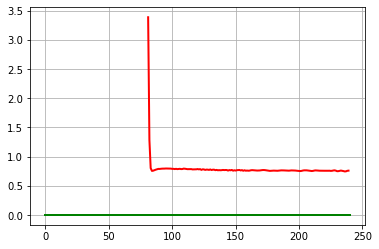

In [31]:
accuracy_history = np.array(acc_cov_diff)
step = 1
plt.clf()
plt.grid("on", "both")
idx = np.max(np.where(accuracy_history > 3.5))+1

iteration = len(acc_cov_diff)
plt.plot(np.arange(idx,iteration,step), accuracy_history[idx:], linewidth=2, color = 'red')
plt.plot(np.arange(iteration+1), np.zeros(iteration+1), linewidth=2, color = 'green')
#plt.savefig("./plots/accuracy_history_"+model_name+".png")
plt.show()

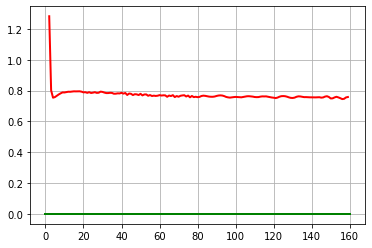

In [32]:
accuracy_history = np.array(acc_cov_diff[80:])
step = 1
plt.clf()
plt.grid("on", "both")
idx = np.max(np.where(accuracy_history > 2.5))+1

iteration = len(accuracy_history)
plt.plot(np.arange(idx,iteration,step), accuracy_history[idx:], linewidth=2, color = 'red')
plt.plot(np.arange(iteration+1), np.zeros(iteration+1), linewidth=2, color = 'green')
#plt.savefig("./plots/accuracy_history_"+model_name+".png")
plt.show()

In [19]:
np.max(np.where(accuracy_history > 3.5))

0

In [34]:
with open('./training_process_dump/' + model_name + '.pkl', 'wb') as f:
    pkl.dump([res,acc_cov_diff], f)

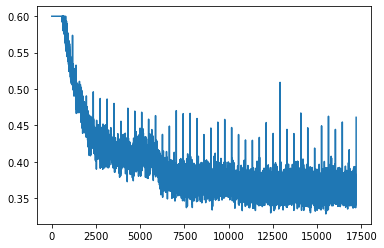

In [22]:
plt.plot(np.minimum(cov_diff_all, 0.6))

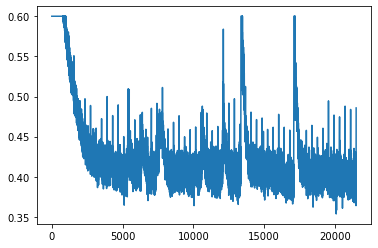

In [15]:
plt.plot(np.minimum(cov_diff_all, 0.6))#Df,Dr(lr=0.005), Dff(lr=0.01) -- RMSProp, G -- Adam(lr = 0.005)

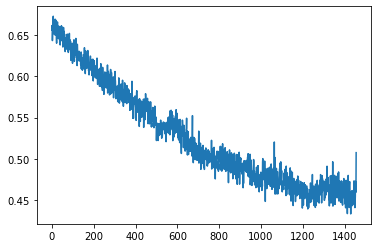

In [13]:
plt.plot(cov_diff_all[500:])#Df,Dr(lr=0.005), Dff(lr=0.01) -- RMSProp, G -- Adam(lr = 0.005)

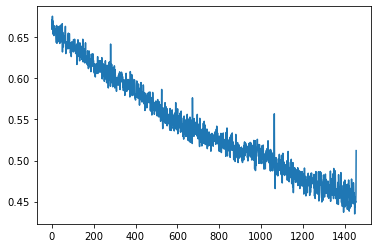

In [13]:
plt.plot(cov_diff_all[500:])#Df,Dr(lr=0.005), Dff(lr=0.01) -- RMSProp, G -- Adam(lr = 0.003)

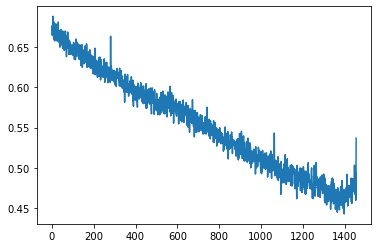

In [23]:
plt.plot(cov_diff_all[500:])#Df,Dr(lr=0.01), Dff(lr=0.01) -- RMSProp, G -- Adam

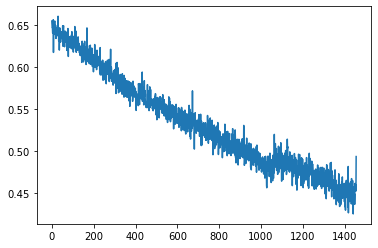

In [13]:
plt.plot(cov_diff_all[500:])#Df,Dr(lr=default), Dff(lr=0.01) -- RMSProp, G -- Adam, no detach in D_ff

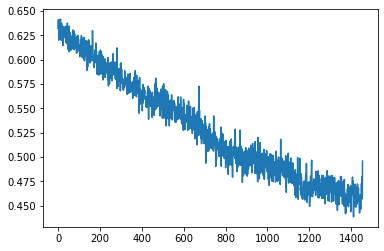

In [13]:
plt.plot(cov_diff_all[500:])#Df,Dr(lr=default), Dff(lr=0.01) -- RMSProp, G -- Adam

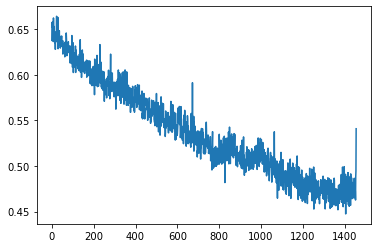

In [13]:
#plt.plot(cov_diff_all[500:])#Df,Dr(lr=default) -- Adam, Dff(lr=0.01) -- RMSProp, G -- Adam

In [35]:
losses = []
for epoch in res['loss']:
    losses += res['loss'][epoch]

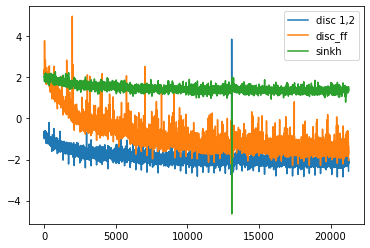

In [36]:
plt.plot(losses[250:])
plt.legend(['disc 1,2','disc_ff','sinkh'])

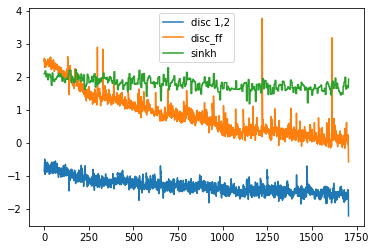

In [15]:
plt.plot(losses[250:])
plt.legend(['disc 1,2','disc_ff','sinkh'])

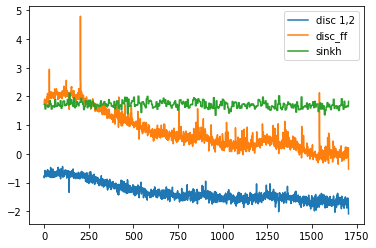

In [16]:
#plt.plot(losses[250:])
#plt.legend(['disc 1,2','disc_ff','sinkh'])

In [30]:
a = [1,2,3]

In [31]:
a[1::1]

[2, 3]

In [2]:
# This code is heavily based on Jan Mentzen's implementation of a VAE (https://jmetzen.github.io/2015-11-27/vae.html)

import numpy as np
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import pickle as pkl

from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, Module
from torch.nn.init import kaiming_uniform_, xavier_uniform_
import torch.nn as nn

np.random.seed(0)

import torch
import geomloss

from geomloss.utils import squared_distances

import argparse

# parser = argparse.ArgumentParser(description='Process args for GAN.')
# parser.add_argument('--weight_init', default = 'he')
# parser.add_argument('--latent_dim', type = int, default = 32)
# parser.add_argument('--lamb', type = float, default = .5)
# args = parser.parse_args()


DIM = 64 # Model dimensionality (number of neurons in the hidden layer(s))
CRITIC_ITERS = 5 # How many critic iterations (Sinkhorn iterations) per generator iteration#was 50
BATCH_SIZE = 256 # Batch size
EPOCHS = 1#55#100000 # how many generator iterations to train for
DATA_DIM = 32
LATENT_DIM = 8#args.latent_dim
INITIALIZATION = 'he'#args.weight_init#'glorot'
COVARIANCE_SCALE = np.sqrt(DATA_DIM)
INITIALIZE_LAST = True
SAMPLE_SIZE = 100000
LAMBDA = 2#args.lamb
MODE = "divergence"

def initializer(weight):
    if INITIALIZATION == 'he':
        return kaiming_uniform_(weight, nonlinearity='relu')
    if INITIALIZATION == 'glorot':
        return xavier_uniform_(weight)
    print("UNKNOWN INITIALIZATION")
    return None

def init_weights(m):
    if type(m) == nn.Linear:
        initializer(m.weight)
        
class GaussianDataset(Dataset):
    # reading the csv and defining predictor and output columns
    def __init__(self, sample_size=SAMPLE_SIZE, data_dim=DATA_DIM, latent_dim = LATENT_DIM,
                 variance = 1/COVARIANCE_SCALE):
    
        # store the input and output features
        
        np.random.seed(1)
        self.X = np.random.randn(sample_size,data_dim) * np.sqrt(variance)
        self.latent_dim = latent_dim
    
        # ensure all data is numerical - type(float)
        self.X = self.X.astype('float32')
    
    # number of rows in dataset
    def __len__(self):
        return len(self.X)
    
    # get a row at an index
    def __getitem__(self, index):
        return [np.random.randn(self.latent_dim).astype('float32'), self.X[index], 
                np.random.randn(self.latent_dim).astype('float32'), 
                np.random.randn(self.latent_dim).astype('float32')]
dataset = GaussianDataset()
data_dl = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

class Generator(Module):
    def __init__(self, n_inputs = LATENT_DIM):
        super(Generator, self).__init__()

        self.model = nn.Sequential(        
        # defining the inputs to the first hidden layer
            Linear(n_inputs, DIM) ,
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, DATA_DIM),
        )
        self.model.apply(init_weights)

    def forward(self, X):
        X = self.model(X)
        return X

class Discriminator(Module):
    def __init__(self, n_inputs = DATA_DIM):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(        
        # defining the inputs to the first hidden layer
            Linear(n_inputs, DIM) ,
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, DIM),
            ReLU(),
            Linear(DIM, 1),
        )
        self.model.apply(init_weights)

    def forward(self, X):
        X = self.model(X)
        return X
    
# Initialize generator and discriminator
generator = Generator()
discriminator_fake = Discriminator() #for fake data (hat_Y) in W(Y, hat_Y)
discriminator_real = Discriminator() #for real data (Y) in W(Y, hat_Y)
discriminator_ff = Discriminator() #for fake data (hat_Y) in W(hat_Y, hat_Y)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr = 0.003)
optimizer_Df = torch.optim.RMSprop(discriminator_fake.parameters(),lr=0.005)
optimizer_Dr = torch.optim.RMSprop(discriminator_real.parameters(),lr=0.005)
optimizer_Dff = torch.optim.RMSprop(discriminator_ff.parameters(), lr = 0.01)
#optimizer_Dr = torch.optim.RMSprop()
#optimizer_Dff = torch.optim.RMSprop(discriminator_ff.parameters())

eps = LAMBDA
def sinkhorn_loss_dual(dual_fake, dual_real, cost_mat):#this is a negative loss
    log_pi = (dual_real.T+dual_fake - cost_mat)/eps
    reg_term = (log_pi).logsumexp((0,1))
    W_neg = - dual_fake.mean() - dual_real.mean() + eps*reg_term 
    return W_neg

res = {'loss':{}, 'sample': {}, 'cov_diff' : {}}
res['lambda'] = LAMBDA
cov_diff_all = []
epochs = EPOCHS


acc_cov_diff = []

cov_diff_inp = torch.tensor(np.random.randn(10*BATCH_SIZE, LATENT_DIM).astype('float32'))


epochs_passed = len(list(res['loss'].keys()))#to continue training 
loss_G = 0
for epoch in range(epochs_passed, epochs_passed+epochs):
    if epoch == 15:
            optimizer_G.param_groups[0]['lr'] = 0.001
    if epoch == 25:
            optimizer_G.param_groups[0]['lr'] = 0.0007
    if epoch == 35:
            optimizer_G.param_groups[0]['lr'] = 0.0005
            optimizer_Df.param_groups[0]['lr'] = 0.0025
            optimizer_Dr.param_groups[0]['lr'] = 0.0025
            optimizer_Dff.param_groups[0]['lr'] = 0.005
    for key in res:
        if key != 'lambda':
            res[key][epoch] = []
    # go through all the batches generated by dataloader
    for i, (inputs, real_sample, inputs0, inputs1) in enumerate(data_dl):
        # clear the gradients
        optimizer_Dr.zero_grad()
        optimizer_Df.zero_grad()
        optimizer_Dff.zero_grad()
        
        # compute the discriminator model outputs & update
        fake_sample = generator(inputs)
        
        cov_diff = np.linalg.norm(np.cov(np.array(fake_sample.data).T) - np.eye(DATA_DIM)/COVARIANCE_SCALE)
        cost_mat = squared_distances(fake_sample, real_sample)
        dual_fake = discriminator_fake(fake_sample)
        dual_real = discriminator_real(real_sample)
        loss_dual = sinkhorn_loss_dual(dual_fake, dual_real, cost_mat)
        loss_dual.backward()
        optimizer_Dr.step()
        optimizer_Df.step()
        
        #Sinkhorn negentropy update
        fake_sample0 = generator(inputs0)
        fake_sample1 = generator(inputs1)
        cost_mat_ff = squared_distances(fake_sample0, fake_sample1)
        dual_ff0 = discriminator_ff(fake_sample0)
        dual_ff1 = discriminator_ff(fake_sample1)
        loss_dual_f = sinkhorn_loss_dual(dual_ff0, dual_ff1, cost_mat_ff)
        loss_dual_f.backward()
        optimizer_Dff.step()
        
        if i % CRITIC_ITERS == 0 and i>0:
            # -----------------
            #  Train Generator
            # -----------------
            print("Generator step")
            optimizer_G.zero_grad()
            
            fake_sample = generator(inputs)
            cost_mat = squared_distances(fake_sample, real_sample)
            dual_fake = discriminator_fake(fake_sample)
            dual_real = discriminator_real(real_sample)
            loss_dual = sinkhorn_loss_dual(dual_fake, dual_real, cost_mat)
            fake_sample0 = generator(inputs0)
            fake_sample1 = generator(inputs1)
            cost_mat_ff = squared_distances(fake_sample0, fake_sample1)
            dual_ff0 = discriminator_ff(fake_sample0)
            dual_ff1 = discriminator_ff(fake_sample1)
            loss_dual_f = sinkhorn_loss_dual(dual_ff0, dual_ff1, cost_mat_ff)
            
            loss_G = - loss_dual + 0.5*loss_dual_f
            loss_G.backward()
            optimizer_G.step()
        if i % 50 == 0:
            fake_sample = generator(cov_diff_inp)
            acc_cov_diff += [np.linalg.norm(np.cov(np.array(fake_sample.data).T) - 
                                      np.eye(DATA_DIM)/COVARIANCE_SCALE)]
            
        print("Epoch: {}, iteration {}, loss {:.4f}, loss_f {:.4f}, , loss_G {:.4f}, cov_diff {}".format(epoch,
                                                                                        i, loss_dual, 
                                                                                       loss_dual_f, loss_G, 
                                                                                       cov_diff))
        res['loss'][epoch].append([loss_dual, loss_dual_f, loss_G])
        res['sample'][epoch].append(np.array(fake_sample.data))
        res['cov_diff'][epoch].append(cov_diff)
    cov_diff_all += res['cov_diff'][epoch]
    
if MODE == 'divergence':
    model_name = "P_SINKHORN_LAMBDA_"#P = parametric
else:
    model_name = "P_ENTROPIC_LAMBDA_"
model_name = model_name +str(LAMBDA) + "_LATENT_DIM_" + str(LATENT_DIM) + "_initialization_" + INITIALIZATION


Epoch: 0, iteration 0, loss 5.2622, loss_f 7.6322, , loss_G 0.0000, cov_diff 7.954428155107681
Epoch: 0, iteration 1, loss -4.8521, loss_f 706.0950, , loss_G 0.0000, cov_diff 6.389832831299533
Epoch: 0, iteration 2, loss 25.8757, loss_f 215.9203, , loss_G 0.0000, cov_diff 6.5648098719527
Epoch: 0, iteration 3, loss -14.1523, loss_f 10.9444, , loss_G 0.0000, cov_diff 6.333309625518603
Epoch: 0, iteration 4, loss -20.5066, loss_f 19.1626, , loss_G 0.0000, cov_diff 7.471902113374785
Generator step
Epoch: 0, iteration 5, loss -16.7298, loss_f 8.9043, , loss_G 21.1819, cov_diff 7.239193255986548
Epoch: 0, iteration 6, loss -3.3686, loss_f 7.8684, , loss_G 21.1819, cov_diff 6.391479358202467
Epoch: 0, iteration 7, loss -10.5465, loss_f 7.5810, , loss_G 21.1819, cov_diff 5.981019173227736
Epoch: 0, iteration 8, loss -11.4653, loss_f 8.0833, , loss_G 21.1819, cov_diff 5.553915836989004
Epoch: 0, iteration 9, loss -11.9424, loss_f 8.5054, , loss_G 21.1819, cov_diff 5.826798522506025
Generator s

Epoch: 0, iteration 88, loss 14.7497, loss_f 18.1043, , loss_G -5.5667, cov_diff 0.7573899305526581
Epoch: 0, iteration 89, loss 14.6401, loss_f 18.0840, , loss_G -5.5667, cov_diff 0.745357493214703
Generator step
Epoch: 0, iteration 90, loss 14.6138, loss_f 18.0801, , loss_G -5.5738, cov_diff 0.7549783538781497
Epoch: 0, iteration 91, loss 14.8750, loss_f 18.4924, , loss_G -5.5738, cov_diff 0.7594241792936702
Epoch: 0, iteration 92, loss 14.8545, loss_f 18.3170, , loss_G -5.5738, cov_diff 0.7782037266150692
Epoch: 0, iteration 93, loss 14.9002, loss_f 18.3430, , loss_G -5.5738, cov_diff 0.7699086991134002
Epoch: 0, iteration 94, loss 14.6401, loss_f 18.4742, , loss_G -5.5738, cov_diff 0.7692605318414172
Generator step
Epoch: 0, iteration 95, loss 14.5385, loss_f 18.4002, , loss_G -5.3384, cov_diff 0.7691426963039005
Epoch: 0, iteration 96, loss 14.7675, loss_f 18.4480, , loss_G -5.3384, cov_diff 0.7584248529926257
Epoch: 0, iteration 97, loss 14.7762, loss_f 18.5646, , loss_G -5.3384,

Epoch: 0, iteration 177, loss 15.5728, loss_f 19.9066, , loss_G -5.6990, cov_diff 0.81715502829118
Epoch: 0, iteration 178, loss 15.5189, loss_f 19.9376, , loss_G -5.6990, cov_diff 0.8206419412984219
Epoch: 0, iteration 179, loss 15.5358, loss_f 19.9568, , loss_G -5.6990, cov_diff 0.8286628374926956
Generator step
Epoch: 0, iteration 180, loss 15.5928, loss_f 19.9097, , loss_G -5.6380, cov_diff 0.8252739315741654
Epoch: 0, iteration 181, loss 15.6745, loss_f 19.9396, , loss_G -5.6380, cov_diff 0.8306782059319523
Epoch: 0, iteration 182, loss 15.5532, loss_f 19.9009, , loss_G -5.6380, cov_diff 0.8253563557667785
Epoch: 0, iteration 183, loss 15.4279, loss_f 19.7603, , loss_G -5.6380, cov_diff 0.8184019931100255
Epoch: 0, iteration 184, loss 15.5312, loss_f 19.9885, , loss_G -5.6380, cov_diff 0.8210264905945518
Generator step
Epoch: 0, iteration 185, loss 15.5935, loss_f 20.0101, , loss_G -5.5885, cov_diff 0.8286591611046964
Epoch: 0, iteration 186, loss 15.5534, loss_f 20.0092, , loss_G

Epoch: 0, iteration 262, loss 15.6618, loss_f 19.9520, , loss_G -5.5217, cov_diff 0.8220165441924695
Epoch: 0, iteration 263, loss 15.6194, loss_f 19.8660, , loss_G -5.5217, cov_diff 0.8186054341151073
Epoch: 0, iteration 264, loss 15.4580, loss_f 19.8946, , loss_G -5.5217, cov_diff 0.8165959725331344
Generator step
Epoch: 0, iteration 265, loss 15.4903, loss_f 19.9145, , loss_G -5.5331, cov_diff 0.8213805190929574
Epoch: 0, iteration 266, loss 15.7195, loss_f 19.8044, , loss_G -5.5331, cov_diff 0.8240247733494905
Epoch: 0, iteration 267, loss 15.5620, loss_f 19.8771, , loss_G -5.5331, cov_diff 0.8275041265360884
Epoch: 0, iteration 268, loss 15.5331, loss_f 19.8534, , loss_G -5.5331, cov_diff 0.8260950320672213
Epoch: 0, iteration 269, loss 15.6127, loss_f 19.9150, , loss_G -5.5331, cov_diff 0.8249402396911022
Generator step
Epoch: 0, iteration 270, loss 15.5314, loss_f 19.9261, , loss_G -5.5684, cov_diff 0.8227461869968707
Epoch: 0, iteration 271, loss 15.8003, loss_f 19.8062, , loss

Epoch: 0, iteration 349, loss 15.6528, loss_f 19.7513, , loss_G -5.6138, cov_diff 0.825459669828439
Generator step
Epoch: 0, iteration 350, loss 15.2062, loss_f 19.6003, , loss_G -5.4060, cov_diff 0.8025740767103599
Epoch: 0, iteration 351, loss 15.3458, loss_f 19.5877, , loss_G -5.4060, cov_diff 0.7985446358600952
Epoch: 0, iteration 352, loss 15.5013, loss_f 19.6829, , loss_G -5.4060, cov_diff 0.7970934928717627
Epoch: 0, iteration 353, loss 15.2788, loss_f 19.7654, , loss_G -5.4060, cov_diff 0.8085025416014054
Epoch: 0, iteration 354, loss 15.6327, loss_f 19.5158, , loss_G -5.4060, cov_diff 0.8284728032891939
Generator step
Epoch: 0, iteration 355, loss 15.2589, loss_f 19.6544, , loss_G -5.4317, cov_diff 0.8019358869489569
Epoch: 0, iteration 356, loss 15.4477, loss_f 19.6413, , loss_G -5.4317, cov_diff 0.8064384746032828
Epoch: 0, iteration 357, loss 15.3910, loss_f 19.6486, , loss_G -5.4317, cov_diff 0.8083880235762468
Epoch: 0, iteration 358, loss 15.2330, loss_f 19.6673, , loss_

In [5]:

plt.figure()
accuracy_history = np.array(acc_cov_diff[:400])
iteration = min(20000, len(accuracy_history)*50)
step = 50
plt.clf()
plt.grid("on", "both")
idx = np.max(np.where(accuracy_history > 3.5))
plt.plot(np.arange(idx*50,iteration,step), accuracy_history[idx:], linewidth=2, color = 'red')
plt.plot(np.arange(iteration+1), np.zeros(iteration+1), linewidth=2, color = 'green')
